## Tutorial: Generating Observing Scenario with CAPyBARA


### 1. Setup and Imports

Before running the example notebook, you need to create jacobian files:

    python run_CAPyBARA.py --mode jacobian --config capy-pup-900.ini

When creating jacobian file, you do not need the filename in there but afterwards, filename normally handle by the output function so it will be in : 


    YYYY-MM-DD_jacobian_matrix_<wvl>nm.fit 

To update your config file, do the following. <wvl> is handled by the parameter setup (same as wvl field in the efc)

In [ ]:
""" 
[path]
data_path = # your path 
jacobian = # file name here , e.g. 2024-12-06_jacobian_matrix_
"""

In [3]:
#%%
import matplotlib.pyplot as plt
import numpy as np

import CAPyBARA.aberration as rst_aberration
from hcipy import *
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)

from astropy.io import fits
from CAPyBARA.rst_design import _make_rst_aperture, _make_lyot_mask
from CAPyBARA.rst_functions import *
import scipy.fftpack
import os   
import sys
import copy  # Use the copy module to perform deep copies

plt.rcParams['image.origin'] = 'lower'

import CAPyBARA.rst_functions as rst_func
from CAPyBARA.plotting import plt_field, plt_std_vs_iteration
from CAPyBARA.efc import EFieldConjugation 

import CAPyBARA.plotting  as plotting

import time
import yaml
import argparse

from datetime import datetime
from CAPyBARA import CAPyBARAsim


import CAPyBARA.utils as utils
from CAPyBARA.utils import read_ini_file, load_and_print_default_txt
from CAPyBARA.output import *
# Set matplotlib style
plt.style.use(astropy_mpl_style)
plt.rcParams['image.origin'] = 'lower'

Note: you may need to restart the kernel to use updated packages.


ModuleNotFoundError: No module named 'CAPyBARA'

In [ ]:
# parameter to define 
path = '/Repo/CAPyBARA/'
ini_file = 'example/capy-pup-900.ini'

mode = 'broadband'

In [3]:
param_rst = read_ini_file(os.path.join(path, ini_file))

print(param_rst['telescope'])

{'diameter': 2.36, 'central_obs': 0.303, 'radius_pupil_pixels': 336, 'f_number': 7.9, 'num_actuator': 48, 'iwa': 3.0, 'owa': 9.0, 'radius_hlc_obstruction': 2.6}


In [4]:
path = param_rst['path']['data_path']
param_rst['jacobian'] = param_rst['path']['data_path']+param_rst['path']['jacobian']

print(param_rst)

{'path': {'data_path': '/Users/ylau/Data/CAPyBARA/', 'jacobian': '2024-12-06_jacobian_matrix_'}, 'efc': {'wvl': [555, 575, 595], 'loop_gain': 0.5, 'num_iteration': 25, 'rcond': 0.01, 'num_mode': 21, 'implementation_parameter': 0.1, 'leaking_factor': 1.0, 'ref_wvl': 575}, 'observation': {'wvl': [555, 565, 575, 585, 595], 'last_dm_command': 'None', 'num_iteration': 120, 'num_mode': 21, 'aberration_ptv': 0.3, 'implementation_parameter': 0.1, 'leaking_factor': 1, 'ref_wvl': 575, 'loop_gain': 0.5, 'num_probe_iteration': 5, 'probe_mode': 'zernike', 'is_single': True}, 'telescope': {'diameter': 2.36, 'central_obs': 0.303, 'radius_pupil_pixels': 336, 'f_number': 7.9, 'num_actuator': 48, 'iwa': 3.0, 'owa': 9.0, 'radius_hlc_obstruction': 2.6}, 'sequence': {'is_efc': True, 'is_observation': True}, 'jacobian': '/Users/ylau/Data/CAPyBARA/2024-12-06_jacobian_matrix_'}


In [6]:
base_data_path = param_rst["path"]["data_path"]

experiment_dir = create_experiment_dir(base_data_path)

copy_run_metadata(
    output_dir=experiment_dir,
    ini_path="capy-pup-900.ini",
    log_path="capybara.log",
)

In [7]:
def get_rms_field(arr, aperture, opd2phase):
    """Calculate RMS of phase map in nanometers."""
    aperture_mask = aperture > 0
    rms = np.sqrt(np.sum(arr**2 * aperture_mask) / np.sum(aperture_mask))
    return rms * (1/opd2phase) / 1e-9

def plot_std(array, opd2phase, aperture):
    """Plot RMS evolution over iterations."""
    n_field_std = []
    for i in range(len(array)):
        n_field_std.append(get_rms_field(array[i], aperture, opd2phase))
    
    plt.figure(figsize=(10, 6))
    plt.plot(n_field_std, label='RMS of aberration', linewidth=2)
    plt.xlabel('Iteration number')
    plt.ylabel('RMS of aberration [nm]')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

def normalize_phase_to_rms(phase, target_rms):
    """Normalize a phase map to target RMS value."""
    current_rms = np.sqrt(np.mean(phase**2))
    if current_rms == 0:
        raise ValueError("Phase map has zero RMS")
    return phase * (target_rms / current_rms)

print("✓ Utility functions defined!")

✓ Utility functions defined!


### 2. Understanding the telescope setup

CAPyBARA simulates the Roman Space Telescope Coronagrpahic Instrument (Roman CGI), which has:
- **Primary mirror diameter:** 2.36 m
- **Central obscuration:** 0.303 (30.3% of diameter)
- **Six support structs** (spiders)

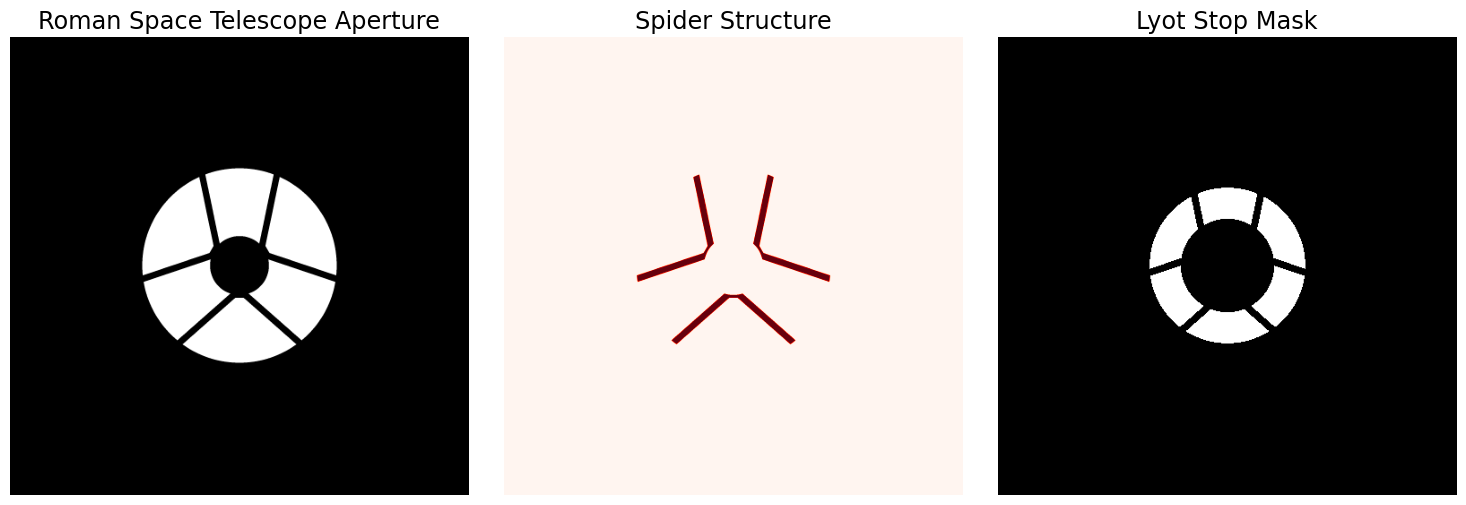

Aperture area: 11.5% of inscribed circle


In [8]:
# Create a pupil grid
pupil_grid = make_pupil_grid(512, diameter=2.36)

# Generate the RST aperture
aperture_func = _make_rst_aperture(normalized=True, with_spiders=True)
aperture = evaluate_supersampled(aperture_func, pupil_grid, 4)

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Full aperture
axes[0].imshow(aperture.shaped, cmap='gray')
axes[0].set_title('Roman Space Telescope Aperture')
axes[0].axis('off')

# Just the spiders
aperture_no_spiders = evaluate_supersampled(
    _make_rst_aperture(normalized=True, with_spiders=False), 
    pupil_grid, 4
)
spider_mask = aperture_no_spiders - aperture
axes[1].imshow(spider_mask.shaped, cmap='Reds')
axes[1].set_title('Spider Structure')
axes[1].axis('off')

# Lyot stop (used for coronagraphy)
lyot_func = _make_lyot_mask(normalized=True, with_spiders=True)
lyot_mask = lyot_func(pupil_grid)
axes[2].imshow(lyot_mask.shaped, cmap='gray')
axes[2].set_title('Lyot Stop Mask')
axes[2].axis('off')

plt.tight_layout()
plt.show()

print(f"Aperture area: {np.sum(aperture) / len(aperture) * 100:.1f}% of inscribed circle")

### 3. Creating the first simulation

In [9]:
# Initialize lists for multiple wavelengths
CAPyBARA_list = []
aberration_class_list = []
n_zernike_coeff_list = []

print(f"\n=== Setting up {len(param_rst['efc']['wvl'])} wavelength channels ===")

for i in range(len(param_rst['efc']['wvl'])):
    print(f"\n--- Wavelength {i+1}: {param_rst['efc']['wvl'][i]} nm ---")
    
    # Deep copy parameters for this wavelength
    _param = copy.deepcopy(param_rst)
    _param['efc']['wvl'] = param_rst['efc']['wvl'][i]
    
    # Initialize CAPyBARA instance
    CAPyBARA = CAPyBARAsim(_param['telescope'])
    CAPyBARA.get_param(_param, sequence='efc')
    CAPyBARA.get_grid()
    
    # Create influence function (only once)
    if i == 0:
        print('Calculating influence function...')
        influence_function = make_xinetics_influence_functions(
            CAPyBARA.pupil_grid,
            CAPyBARA.param['num_actuator'],
            CAPyBARA.param['actuator_spacing']
        )
    
    # Setup optical system
    CAPyBARA.get_system(influence_function)
    CAPyBARA.get_prop()
    
    # Setup aberration model
    aberration_class = rst_aberration.CAPyBARAaberration(
        sim=CAPyBARA,
        param=_param['efc']
    )
    aberration_class.set_aberration()
    
    # Get reference image with static aberrations
    CAPyBARA.get_reference_image(
        _param['efc']['wvl'] * 1e-9,
        aberration_class.static_aberration_func
    )
    
    # Create Zernike basis for quasi-static aberrations
    aberration_class.set_zernike_basis(num_mode=_param['efc']['num_mode'])
    
    print(f"  ✓ System initialized")
    print(f"  ✓ Reference image calculated")
    print(f"  ✓ {_param['efc']['num_mode']} Zernike modes created")
    
    # Append to lists
    CAPyBARA_list.append(CAPyBARA)
    aberration_class_list.append(aberration_class)

print("\n✓ All wavelength channels initialized!")


=== Setting up 3 wavelength channels ===

--- Wavelength 1: 555 nm ---
Calculating influence function...
2026-01-14 16:18:29,435 - INFO - CAPyBARA.CAPyBARA - Read jacobian matrix: 2024-12-06_jacobian_matrix_
2026-01-14 16:18:29,437 - INFO - CAPyBARA.CAPyBARA - Jacobian type: <class 'str'>
Static aberration


/Users/ylau/Repo/hcipy/hcipy/optics/aberration.py:38: RuntimeWarning: divide by zero encountered in power
  res = Field(grid.as_('polar').r**exponent, grid)


  ✓ System initialized
  ✓ Reference image calculated
  ✓ 21 Zernike modes created

--- Wavelength 2: 575 nm ---
2026-01-14 16:18:29,862 - INFO - CAPyBARA.CAPyBARA - Read jacobian matrix: 2024-12-06_jacobian_matrix_
2026-01-14 16:18:29,863 - INFO - CAPyBARA.CAPyBARA - Jacobian type: <class 'str'>
Static aberration
  ✓ System initialized
  ✓ Reference image calculated
  ✓ 21 Zernike modes created

--- Wavelength 3: 595 nm ---
2026-01-14 16:18:30,327 - INFO - CAPyBARA.CAPyBARA - Read jacobian matrix: 2024-12-06_jacobian_matrix_
2026-01-14 16:18:30,328 - INFO - CAPyBARA.CAPyBARA - Jacobian type: <class 'str'>
Static aberration
  ✓ System initialized
  ✓ Reference image calculated
  ✓ 21 Zernike modes created

✓ All wavelength channels initialized!



=== Generating Aberration Evolution ===
Tracking Zernike component evolution...
2026-01-14 16:18:30,732 - INFO - CAPyBARA.aberration - Fixed seed 1338485434
2026-01-14 16:18:30,733 - INFO - CAPyBARA.aberration - iteration0, 0.0
2026-01-14 16:18:30,734 - INFO - CAPyBARA.aberration - Mode4, c: 0.0
2026-01-14 16:18:30,734 - INFO - CAPyBARA.aberration - Mode5, c: 0.0
2026-01-14 16:18:30,735 - INFO - CAPyBARA.aberration - Mode6, c: 0.0
2026-01-14 16:18:30,735 - INFO - CAPyBARA.aberration - Mode7, c: 0.0
2026-01-14 16:18:30,736 - INFO - CAPyBARA.aberration - Mode8, c: 0.0
2026-01-14 16:18:30,736 - INFO - CAPyBARA.aberration - Mode9, c: 0.0
2026-01-14 16:18:30,737 - INFO - CAPyBARA.aberration - Mode10, c: 0.0
2026-01-14 16:18:30,737 - INFO - CAPyBARA.aberration - Mode11, c: 0.0
2026-01-14 16:18:30,738 - INFO - CAPyBARA.aberration - Mode12, c: 0.0
2026-01-14 16:18:30,738 - INFO - CAPyBARA.aberration - Mode13, c: 0.0
2026-01-14 16:18:30,739 - INFO - CAPyBARA.aberration - Mode14, c: 0.0
2026-01

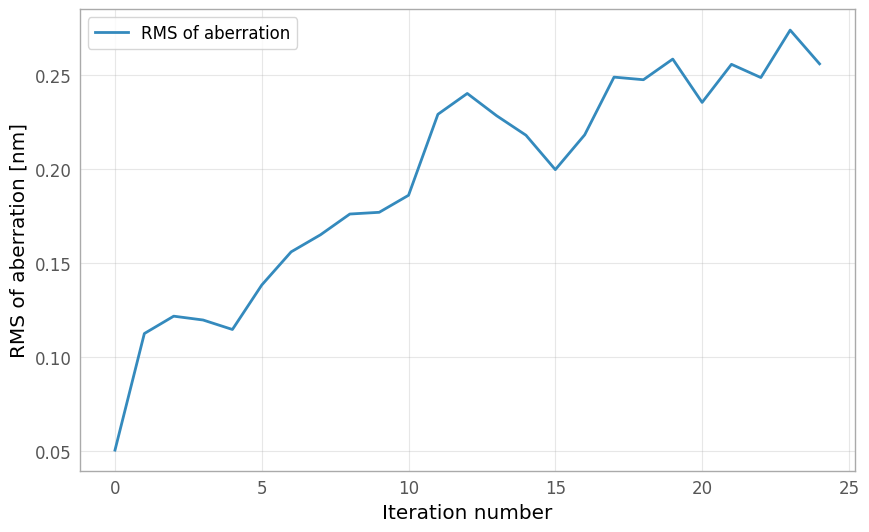

In [10]:
print("\n=== Generating Aberration Evolution ===")

efc_seed = 1338485434

# Extract initial components from reference wavefront
zernike_coeff = np.zeros((_param['efc']['num_mode']))
step0_components_array = aberration_class.extract_component(CAPyBARA.wf_ref.phase)
starting_field = Field(
    np.dot(step0_components_array, aberration_class.zernike_basis),
    CAPyBARA.pupil_grid
)

# Generate time-varying aberrations
print("Tracking Zernike component evolution...")
n_zernike_coeff, n_field, n_aberration = aberration_class.track_zernike_component(
    zernike_coeff=zernike_coeff,
    wvl=CAPyBARA.param['wvl'] * 1e-9,
    starting_field=starting_field,
    seed=efc_seed  # For reproducibility)
)

# Apply to all wavelength channels
for i in range(len(param_rst['efc']['wvl'])):
    aberration_class_list[i].get_aberration_data_cube(n_field)

print(f"✓ Generated {len(n_field)} aberration frames")

# Visualize aberration evolution
opd2phase = 2 * np.pi / (1e-9 * param_rst['observation']['ref_wvl'])
plot_std(n_field, opd2phase, CAPyBARA.aperture)

In [ ]:
print("\n=== Running Broadband EFC ===")

# Initialize EFC controller
efc_exp = EFieldConjugation(CAPyBARA_list, aberration_class_list)

# Convert wavelengths to meters
wavelengths_in_meters = [wvl * 1e-9 for wvl in param_rst['efc']['wvl']]

print(f"Control wavelengths: {param_rst['efc']['wvl']} nm")
print(f"Number of iterations: {param_rst['efc']['num_iteration']}")
print(f"Starting EFC loop...")

# Run control loop
start_time = time.time()
actuators_list, e_field_list, img_list, wf_lyot_list, wf_residual_list = \
    efc_exp.control(wvl=wavelengths_in_meters)
elapsed = time.time() - start_time

print(f"\n✓ EFC completed in {elapsed:.1f} seconds ({elapsed/60:.1f} minutes)")
print(f"  Generated {len(actuators_list)} DM commands")
print(f"  Final image shape: {np.shape(img_list[-1])}")

In [12]:
from CAPyBARA.contrast import calculate_broadband_image_and_contrast

# Calculate EFC contrast evolution
print("\nCalculating broadband contrast...")
wvl_weights = [1, 1, 1]  # Equal weights for all wavelengths
broadband_coron_images, broadband_contrast = calculate_broadband_image_and_contrast(
    CAPyBARA_list, img_list, wvl_weights
)

print(f"✓ Contrast calculated for {len(broadband_contrast)} iterations")
print(f"  Initial contrast: {broadband_contrast[0]:.2e}")
print(f"  Final contrast: {broadband_contrast[-1]:.2e}")


Calculating broadband contrast...
✓ Contrast calculated for 25 iterations
  Initial contrast: 2.10e-05
  Final contrast: 1.88e-08


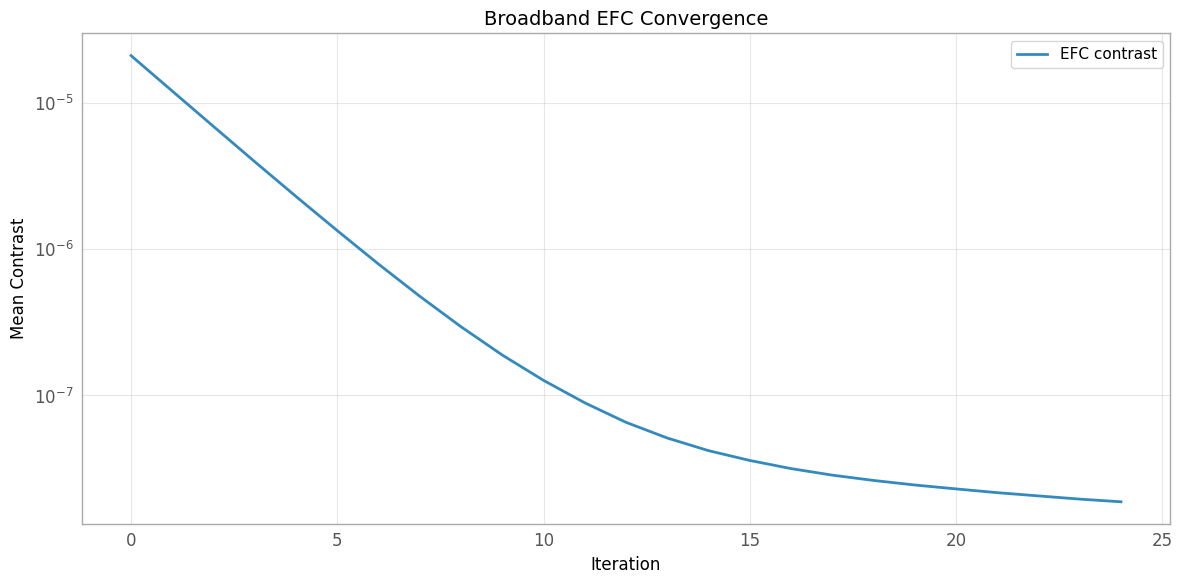

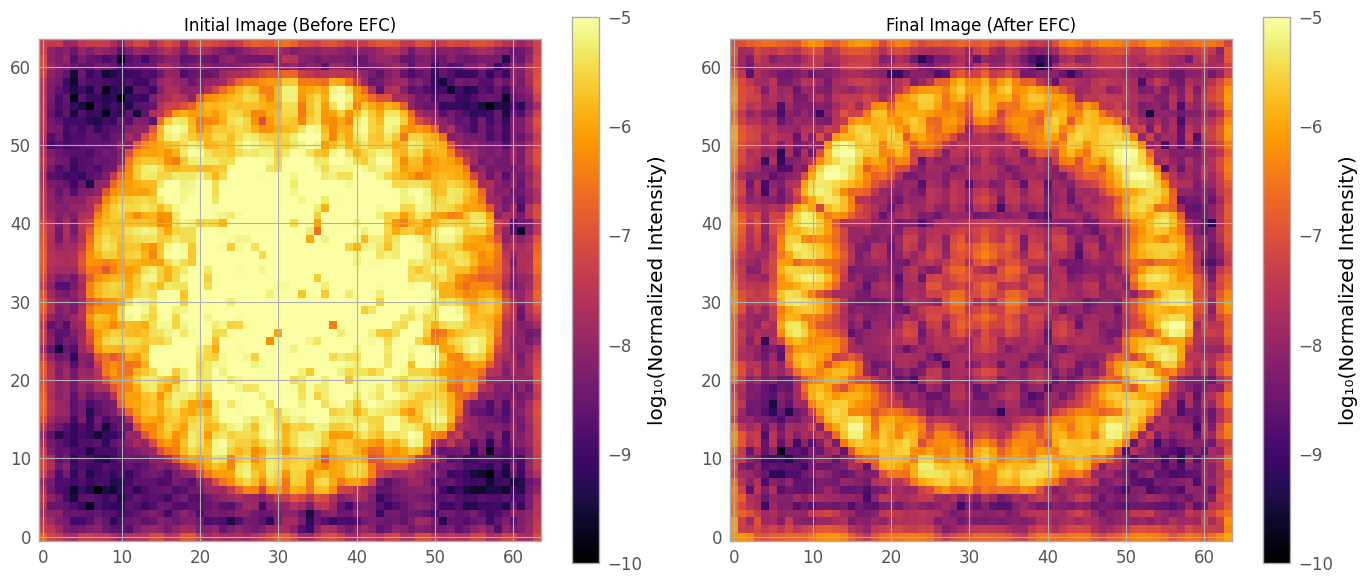

In [13]:
# Plot contrast evolution
plt.figure(figsize=(12, 6))
plt.semilogy(broadband_contrast, linewidth=2, label='EFC contrast')
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Mean Contrast', fontsize=12)
plt.title('Broadband EFC Convergence', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

# Show initial and final images
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

im0 = axes[0].imshow(
    np.log10(broadband_coron_images[0].reshape(64, 64)),
    cmap='inferno', vmin=-10, vmax=-5
)
axes[0].set_title('Initial Image (Before EFC)', fontsize=12)
plt.colorbar(im0, ax=axes[0], label='log₁₀(Normalized Intensity)')

im1 = axes[1].imshow(
    np.log10(broadband_coron_images[-1].reshape(64, 64)),
    cmap='inferno', vmin=-10, vmax=-5
)
axes[1].set_title('Final Image (After EFC)', fontsize=12)
plt.colorbar(im1, ax=axes[1], label='log₁₀(Normalized Intensity)')

plt.tight_layout()
plt.show()

In [ ]:
save_efc_products(
    output_dir=experiment_dir,                 # YYYY-MM-DD_HHMMSS folder
    param_efc=param_rst["efc"],
    img_list=img_list,
    actuator_list=actuators_list,
    sim_list=CAPyBARA_list,                     # list for broadband, single sim for mono
    wvl_weights=[1, 1, 1],                 # or [1.0] for monochromatic
    aberration_cube=n_field,
    seed=efc_seed,
    wavelengths_nm=param_rst["efc"]["wvl"],
    parameters_snapshot={
        "ini_file": "capy-pup-900.ini",
        "efc": param_rst["efc"],
        "telescope": param_rst["telescope"],
    },
)


In [15]:
print("\n=== Setting up Observing Sequence ===")

obs_list = []
obs_aberration_class_list = []

# Final DM command from EFC
current_actuators = actuators_list[-1]

for i in range(len(param_rst['observation']['wvl'])):
    _param = copy.deepcopy(param_rst)
    _param['observation']['wvl'] = param_rst['observation']['wvl'][i]
    _wvl = _param['observation']['wvl']
    
    print(f"Setting up wavelength {i+1}: {_wvl} nm")
    
    # Initialize observation system
    obs = CAPyBARAsim(_param['telescope'])
    obs.get_param(_param, sequence='observation')
    obs.get_grid()
    
    if i == 0:
        influence_function = make_xinetics_influence_functions(
            obs.pupil_grid,
            obs.param['num_actuator'],
            obs.param['actuator_spacing']
        )
    
    obs.get_system(influence_function)
    obs.get_prop()
    
    # Setup observation aberrations
    obs_aberration_class = rst_aberration.CAPyBARAaberration(
        sim=obs,
        param=_param['observation']
    )
    obs_aberration_class.set_aberration()
    obs_aberration_class.set_zernike_basis(num_mode=_param['observation']['num_mode'])
    
    # Get reference image
    obs.get_reference_image(
        _wvl * 1e-9,
        obs_aberration_class.static_aberration_func
    )
    obs.apply_actuators(actuators=current_actuators)
    
    obs_list.append(obs)
    obs_aberration_class_list.append(obs_aberration_class)

print("✓ Observation systems initialized!")


=== Setting up Observing Sequence ===
Setting up wavelength 1: 555 nm
2026-01-14 16:20:44,185 - INFO - CAPyBARA.CAPyBARA - Read jacobian matrix: 2024-12-06_jacobian_matrix_
2026-01-14 16:20:44,186 - INFO - CAPyBARA.CAPyBARA - Jacobian type: <class 'str'>
Static aberration
Setting up wavelength 2: 565 nm
2026-01-14 16:20:44,615 - INFO - CAPyBARA.CAPyBARA - Read jacobian matrix: 2024-12-06_jacobian_matrix_
2026-01-14 16:20:44,615 - INFO - CAPyBARA.CAPyBARA - Jacobian type: <class 'str'>
Static aberration
Setting up wavelength 3: 575 nm
2026-01-14 16:20:45,159 - INFO - CAPyBARA.CAPyBARA - Read jacobian matrix: 2024-12-06_jacobian_matrix_
2026-01-14 16:20:45,160 - INFO - CAPyBARA.CAPyBARA - Jacobian type: <class 'str'>
Static aberration
Setting up wavelength 4: 585 nm
2026-01-14 16:20:45,553 - INFO - CAPyBARA.CAPyBARA - Read jacobian matrix: 2024-12-06_jacobian_matrix_
2026-01-14 16:20:45,554 - INFO - CAPyBARA.CAPyBARA - Jacobian type: <class 'str'>
Static aberration
Setting up wavelength

In [ ]:
print("\nGenerating observation aberration sequence...")

ref_obs_seed = 1246748186

# Start from last EFC aberration
starting_field = Field(
    np.dot(n_zernike_coeff[-1], aberration_class.zernike_basis),
    CAPyBARA.pupil_grid
)

# Track aberrations during observation
n_zernike_coeff_obs, n_field_obs, n_aberration_obs = \
    obs_aberration_class.track_zernike_component(
        zernike_coeff=n_zernike_coeff[-1],
        wvl=param_rst['observation']['ref_wvl'] * 1e-9,
        starting_field=starting_field,
        seed=ref_obs_seed
    )

# Apply to all observation wavelengths
for i in range(len(param_rst['observation']['wvl'])):
    obs_aberration_class_list[i].get_aberration_data_cube(n_field_obs)

print(f"✓ Generated {len(n_field_obs)} observation frames")

# Visualize
plot_std(n_field_obs, opd2phase, CAPyBARA.aperture)

In [17]:
print("\n=== Setting up Probe Injection ===")

from CAPyBARA.probe import Probe

# Number of probe frames per amplitude
param_rst['observation']['num_probe_iteration'] = 5

# Initialize probe aberration class
probe_aberration = Probe(
    sim=CAPyBARA,
    param=param_rst['observation']
)
# Set probe modes (Zernike 5-6: astigmatism)
probe_aberration.set_zernike_probe_basis(starting_mode=5, ending_mode=6)

print(f"✓ Probe system initialized")
print(f"  Probe modes: Z5-Z6 (astigmatism)")
print(f"  Frames per amplitude: {param_rst['observation']['num_probe_iteration']}")


=== Setting up Probe Injection ===
✓ Probe system initialized
  Probe modes: Z5-Z6 (astigmatism)
  Frames per amplitude: 5



Generating probe sequence with 4 amplitudes:
  - 0.050 nm
  - 0.038 nm
  - 0.024 nm
  - 0.010 nm
2026-01-14 16:20:48,514 - INFO - CAPyBARA.probe - Inject single-mode Zernike probe
2026-01-14 16:20:48,515 - INFO - CAPyBARA.probe - Injecting + probe, iteration 0
2026-01-14 16:20:48,516 - INFO - CAPyBARA.probe - Injecting + probe, iteration 0 to mode 0
2026-01-14 16:20:48,516 - INFO - CAPyBARA.probe - Inject single-mode Zernike probe
2026-01-14 16:20:48,517 - INFO - CAPyBARA.probe - Injecting + probe, iteration 1
2026-01-14 16:20:48,517 - INFO - CAPyBARA.probe - Injecting + probe, iteration 1 to mode 0
2026-01-14 16:20:48,518 - INFO - CAPyBARA.probe - Inject single-mode Zernike probe
2026-01-14 16:20:48,519 - INFO - CAPyBARA.probe - Injecting + probe, iteration 2
2026-01-14 16:20:48,519 - INFO - CAPyBARA.probe - Injecting + probe, iteration 2 to mode 0
2026-01-14 16:20:48,519 - INFO - CAPyBARA.probe - Inject single-mode Zernike probe
2026-01-14 16:20:48,520 - INFO - CAPyBARA.probe - Inje

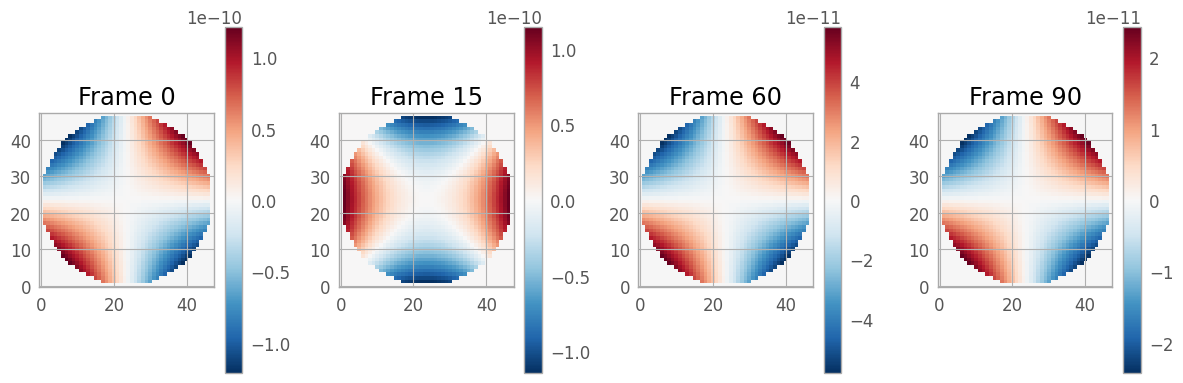

✓ Probe DM commands prepared


In [19]:
# Define probe amplitudes
list_of_amplitudes = [0.05e-9, 0.038e-9, 0.024e-9, 0.01e-9]  # meters
probe_injection_list_dm1 = []

print(f"\nGenerating probe sequence with {len(list_of_amplitudes)} amplitudes:")
for amp in list_of_amplitudes:
    print(f"  - {amp*1e9:.3f} nm")

# Generate probes for 2 modes, 4 amplitudes
for j in range(len(list_of_amplitudes)):
    for i in range(30):  # 30 frames per amplitude
        iteration_idx = i + (j * 30)
        probe_injection_list_dm1.append(
            probe_aberration.apply_zernike_probe(
                amplitude=list_of_amplitudes[j],
                n_iteration=i
            )
        )

print(f"✓ Generated {len(probe_injection_list_dm1)} probe frames")

# Visualize probe pattern
plt.figure(figsize=(12, 4))
for i, idx in enumerate([0, 15, 60, 90]):
    plt.subplot(1, 4, i+1)
    plt.imshow(probe_injection_list_dm1[idx].reshape(48, 48), cmap='RdBu_r')
    plt.title(f'Frame {idx}')
    plt.colorbar()
plt.tight_layout()
plt.show()

# Create full DM commands (DM1 with probes, DM2 zeros)
probe_map_list = []
for i in range(len(probe_injection_list_dm1)):
    custom_probe = np.concatenate((
        CAPyBARA.dm1.actuators + probe_injection_list_dm1[i],
        CAPyBARA.dm2.actuators
    ))
    probe_map_list.append(custom_probe)

print(f"✓ Probe DM commands prepared")

2026-01-14 16:20:49,085 - INFO - CAPyBARA.probe - Inject single-mode Zernike probe
2026-01-14 16:20:49,086 - INFO - CAPyBARA.probe - Injecting + probe, iteration 0
2026-01-14 16:20:49,087 - INFO - CAPyBARA.probe - Injecting + probe, iteration 0 to mode 0
Probe RMS (nm): 0.04315065661918329


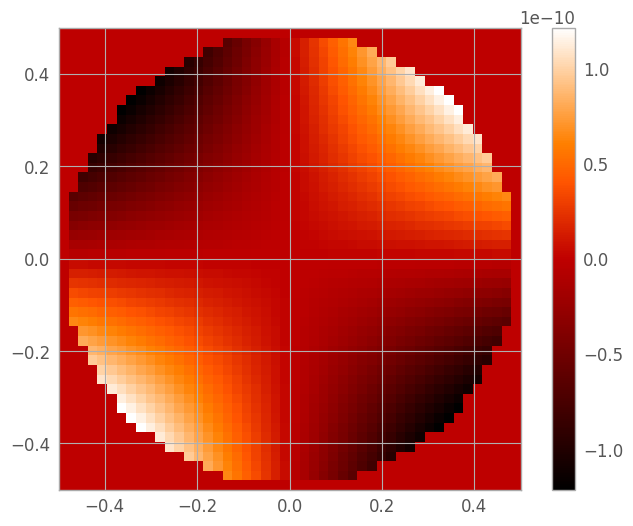

In [20]:
pupil_grid = make_pupil_grid(48)

probe1 = probe_aberration.apply_zernike_probe(
                amplitude=list_of_amplitudes[0],
                n_iteration=0)

imshow_field(probe1,grid=pupil_grid)
plt.colorbar()

print('Probe RMS (nm):', np.sqrt(np.mean(probe1**2))*1e9)

In [ ]:
from CAPyBARA.observing_sequence import ObservingSequence

print("\n=== Running Reference Star Acquisition ===")

# Initialize observing sequence
obs_run = ObservingSequence(obs_list, obs_aberration_class_list)

# Convert wavelengths to meters
wvl = [w * 1e-9 for w in param_rst['observation']['wvl']]

# Run WITHOUT probes
print("Acquiring reference star (without probes)...")
wo_probe_img_list, wo_probe_e_field_list, wo_probe_wf_lyot_list, wo_probe_wf_residual_list = \
    obs_run.acquisition_loop(wvl=wvl, actuators=current_actuators)

# Run WITH probes
print("Acquiring reference star (with probes)...")
w_probe_img_list, w_probe_e_field_list, w_probe_wf_lyot_list, w_probe_wf_residual_list = \
    obs_run.acquisition_loop(wvl=wvl, actuators=probe_map_list)

print(f"✓ Reference star acquisition complete")
print(f"  Frames acquired: {len(wo_probe_img_list)}")

In [ ]:
weights = [1, 1, 1, 1, 1]

save_reference_products(
    output_dir=experiment_dir,
    ref_no_probes_img_list=wo_probe_img_list,
    ref_with_probes_img_list=w_probe_img_list,
    sim_list=obs_list,
    wvl_weights=weights,
    dm_command=probe_map_list,
    aberration_cube=n_field_obs,
    seed=ref_obs_seed,
    param_ref=param_rst["observation"],
    wavelengths_nm=param_rst["observation"]["wvl"],
)


In [ ]:
print("\n=== Running Science Target Acquisition ===")

# Function to add slew/roll offset
def add_slew_offset(last_field, offset_rms_nm, seed):
    """Add a static offset to simulate slew/roll."""
    d_field = normalize_phase_to_rms(last_field, offset_rms_nm * opd2phase)
    step0_components = slew_aberration_class.extract_component(last_field + d_field)
    starting_field = Field(
        np.dot(step0_components, slew_aberration_class.zernike_basis),
        CAPyBARA.pupil_grid
    )
    _, n_field_new, _ = slew_aberration_class.track_zernike_component(
        zernike_coeff=step0_components,
        wvl=CAPyBARA.param['wvl'] * 1e-9,
        starting_field=starting_field,
        seed=seed
    )
    return n_field_new

# Setup slew aberration class
slew_aberration_class = rst_aberration.CAPyBARAaberration(
    sim=CAPyBARA,
    param=param_rst['observation']
)

slew_aberration_class.set_aberration()
slew_aberration_class.set_zernike_basis(num_mode=param_rst['observation']['num_mode'])


# Roll A1 (first science target position)
print("\nRoll A1 (0° position)...")
A1_seed = 1137818213
A1_roll = 0 
slew_offset = 0. 

n_field_A1 = add_slew_offset(n_field_obs[-1], slew_offset, seed=A1_seed)
for i in range(len(obs_aberration_class_list)):
    obs_aberration_class_list[i].get_aberration_data_cube(n_field_A1)

obs_run_A1 = ObservingSequence(obs_list, obs_aberration_class_list)
A1_img_list, _, _, _ = obs_run_A1.acquisition_loop(
    wvl=wvl, actuators=current_actuators
)

# Roll B1 (rotated 26°)
print("Roll B1 (26° position)...")
B1_seed = 1118375116
B1_roll = 26
n_field_B1 = add_slew_offset(n_field_A1[-1], slew_offset, seed=B1_seed)
for i in range(len(obs_aberration_class_list)):
    obs_aberration_class_list[i].get_aberration_data_cube(n_field_B1)

obs_run_B1 = ObservingSequence(obs_list, obs_aberration_class_list)
B1_img_list, _, _, _ = obs_run_B1.acquisition_loop(
    wvl=wvl, actuators=current_actuators
)

# Roll A2 (back to 0°)
print("Roll A2 (return to 0°)...")
A2_seed = 1208545444
A2_roll = 0
n_field_A2 = add_slew_offset(n_field_B1[-1], slew_offset, seed=A2_seed)
for i in range(len(obs_aberration_class_list)):
    obs_aberration_class_list[i].get_aberration_data_cube(n_field_A2)

obs_run_A2 = ObservingSequence(obs_list, obs_aberration_class_list)
A2_img_list, _, _, _ = obs_run_A2.acquisition_loop(
    wvl=wvl, actuators=current_actuators
)

# Roll B2 (back to 26°)
print("Roll B2 (return to 26°)...")
B2_seed = 1286514517
B2_roll = 26
n_field_B2 = add_slew_offset(n_field_A2[-1], slew_offset, seed=B2_seed)
for i in range(len(obs_aberration_class_list)):
    obs_aberration_class_list[i].get_aberration_data_cube(n_field_B2)

obs_run_B2 = ObservingSequence(obs_list, obs_aberration_class_list)
B2_img_list, _, _, _ = obs_run_B2.acquisition_loop(
    wvl=wvl, actuators=current_actuators
)

print("\n✓ All science rolls acquired!")
print("  A1 (0°):  120 frames")
print("  B1 (26°): 120 frames")
print("  A2 (0°):  120 frames")
print("  B2 (26°): 120 frames")

In [35]:
print("\n=== Calculating Contrasts ===")

# Calculate broadband contrast for each sequence
_, contrast_ref_no_probe = calculate_broadband_image_and_contrast(
    obs_list, wo_probe_img_list, [1,1,1,1,1]
)
_, contrast_ref_with_probe = calculate_broadband_image_and_contrast(
    obs_list, w_probe_img_list, [1,1,1,1,1]
)
_, contrast_A1 = calculate_broadband_image_and_contrast(
    obs_list, A1_img_list, [1,1,1,1,1]
)
_, contrast_B1 = calculate_broadband_image_and_contrast(
    obs_list, B1_img_list, [1,1,1,1,1]
)
_, contrast_A2 = calculate_broadband_image_and_contrast(
    obs_list, A2_img_list, [1,1,1,1,1]
)
_, contrast_B2 = calculate_broadband_image_and_contrast(
    obs_list, B2_img_list, [1,1,1,1,1]
)

# Concatenate all contrasts
average_contrasts = (
    broadband_contrast +  # EFC
    contrast_ref_with_probe +  # Reference star
    contrast_A1 + contrast_B1 + contrast_A2 + contrast_B2  # Science rolls
)

print(f"✓ Total frames: {len(average_contrasts)}")


=== Calculating Contrasts ===
✓ Total frames: 625


In [36]:
ref_no_probe_norm_img, contrast_ref_no_probe = calculate_broadband_image_and_contrast(
    obs_list, wo_probe_img_list, [1,1,1,1,1]
)

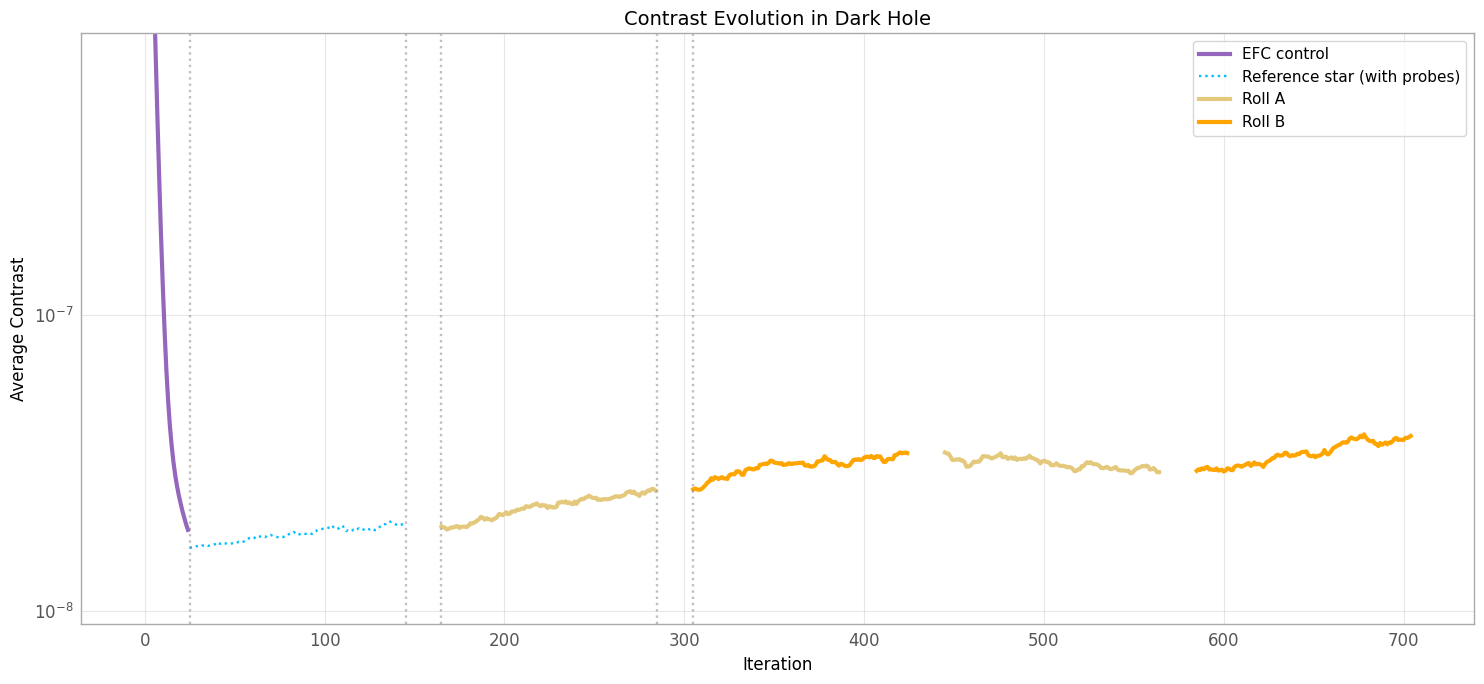

✓ Contrast evolution plot saved


In [37]:
# Main contrast evolution plot
plt.figure(figsize=(15, 7))
plt.title('Contrast Evolution in Dark Hole', fontsize=14)

# Plot each segment
n_efc = len(broadband_contrast)
n_ref = len(contrast_ref_with_probe)
n_roll = len(contrast_A1)

offset = 0
plt.plot(range(offset, offset+n_efc), broadband_contrast,
         color='tab:purple', linewidth=3, label='EFC control')

offset += n_efc
plt.plot(range(offset, offset+n_ref), contrast_ref_with_probe,
         ':', color='deepskyblue', label='Reference star (with probes)')

offset += n_ref + 20  # 20-frame gap
plt.plot(range(offset, offset+n_roll), contrast_A1,
         color='#E4C97C', linewidth=3, label='Roll A')

offset += n_roll + 20
plt.plot(range(offset, offset+n_roll), contrast_B1,
         color='orange', linewidth=3, label='Roll B')

offset += n_roll + 20
plt.plot(range(offset, offset+n_roll), contrast_A2,
         color='#E4C97C', linewidth=3)

offset += n_roll + 20
plt.plot(range(offset, offset+n_roll), contrast_B2,
         color='orange', linewidth=3)

# Add vertical lines for phase transitions
offsets = [n_efc, n_efc+n_ref, n_efc+n_ref+20,
           n_efc+n_ref+20+n_roll, n_efc+n_ref+20+n_roll+20]
for x in offsets:
    plt.axvline(x, color='gray', linestyle=':', alpha=0.5)

plt.yscale('log')
plt.ylim(9e-9, 9e-7)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Average Contrast', fontsize=12)
plt.legend(fontsize=11, loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("✓ Contrast evolution plot saved")

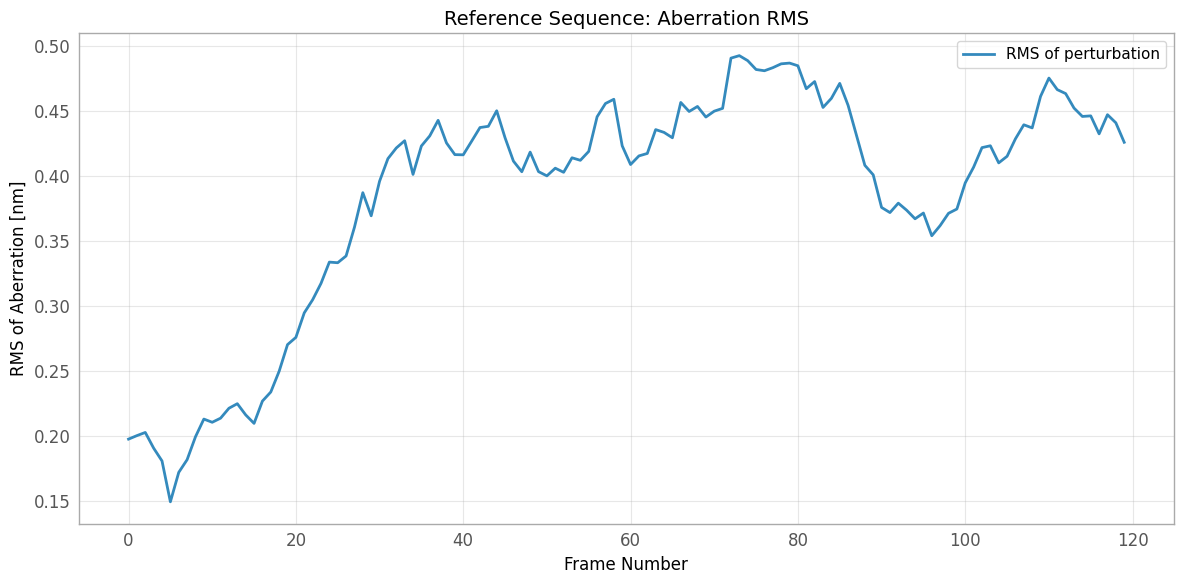

✓ RMS evolution plot for observation saved
  Mean RMS: 0.385 nm
  RMS range: 0.149 - 0.493 nm


In [38]:
# Plot RMS of aberrations for observation sequence
std_obs = []
for frame in n_field_obs:
    std_obs.append(np.std(frame) / (opd2phase * 1e-9))

plt.figure(figsize=(12, 6))
plt.title('Reference Sequence: Aberration RMS', fontsize=14)
plt.plot(std_obs, label='RMS of perturbation', linewidth=2)
plt.xlabel('Frame Number', fontsize=12)
plt.ylabel('RMS of Aberration [nm]', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"✓ RMS evolution plot for observation saved")
print(f"  Mean RMS: {np.mean(std_obs):.3f} nm")
print(f"  RMS range: {np.min(std_obs):.3f} - {np.max(std_obs):.3f} nm")

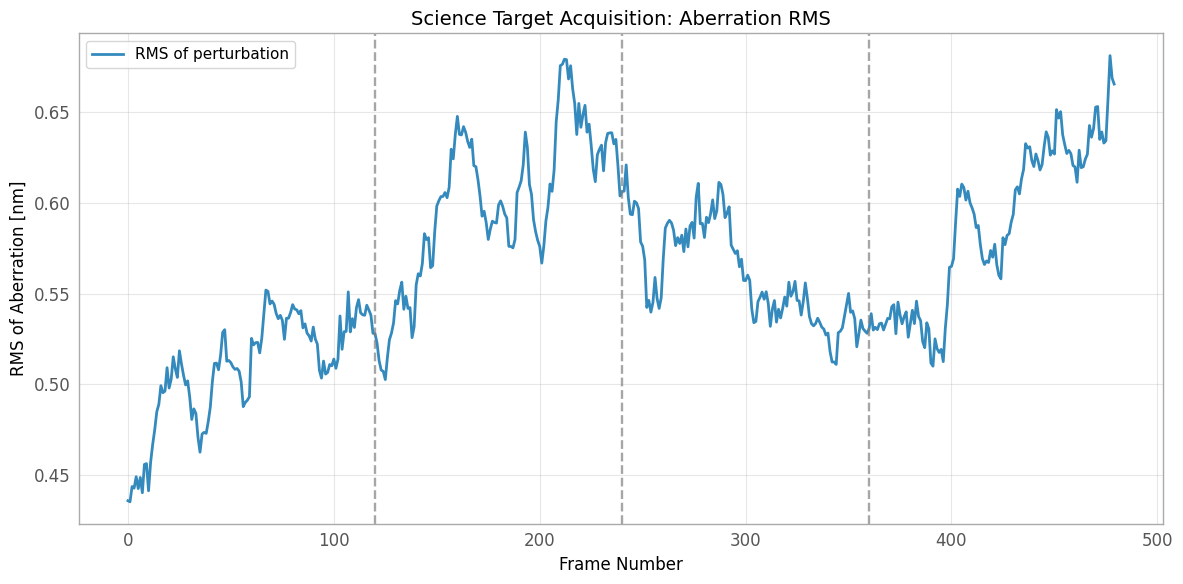

✓ RMS evolution plot saved
  Mean RMS: 0.564 nm
  RMS range: 0.435 - 0.681 nm
  Drift ratio between reference and science: 68.33%


In [39]:
# Plot RMS of aberrations during science acquisition
std_tot = []
fields = [n_field_A1, n_field_B1, n_field_A2, n_field_B2]

for field_set in fields:
    for frame in field_set:
        std_tot.append(np.std(frame) / (opd2phase * 1e-9))

plt.figure(figsize=(12, 6))
plt.title('Science Target Acquisition: Aberration RMS', fontsize=14)
plt.plot(std_tot, label='RMS of perturbation', linewidth=2)
plt.axvline(120, color='gray', linestyle='--', alpha=0.7)
plt.axvline(240, color='gray', linestyle='--', alpha=0.7)
plt.axvline(360, color='gray', linestyle='--', alpha=0.7)
plt.xlabel('Frame Number', fontsize=12)
plt.ylabel('RMS of Aberration [nm]', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
# plt.savefig(os.path.join(save_path, "rms_science.png"), dpi=300, bbox_inches="tight")
plt.show()

print(f"✓ RMS evolution plot saved")
print(f"  Mean RMS: {np.mean(std_tot):.3f} nm")
print(f"  RMS range: {np.min(std_tot):.3f} - {np.max(std_tot):.3f} nm")
print(f"  Drift ratio between reference and science: {100*np.mean(std_obs)/np.mean(std_tot):.2f}%")

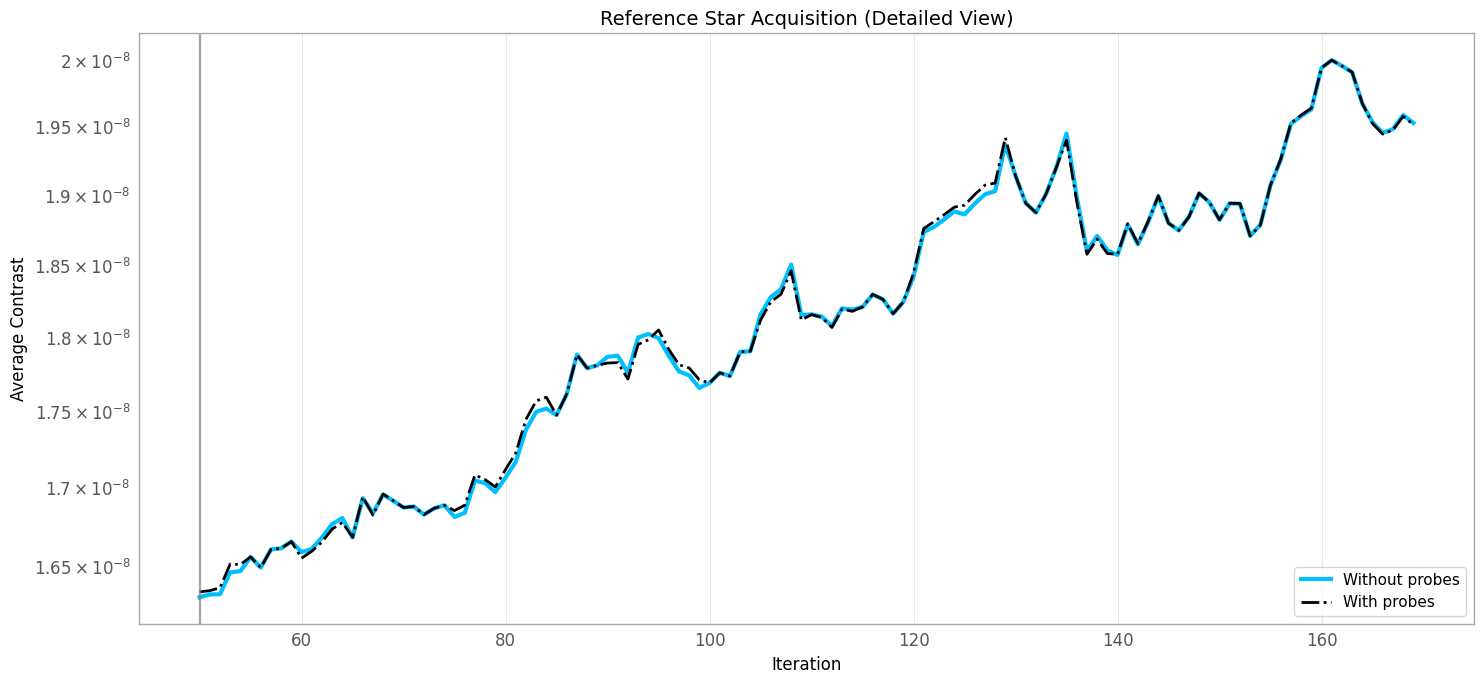

In [40]:
# Detailed view of reference star acquisition
plt.figure(figsize=(15, 7))
plt.title('Reference Star Acquisition (Detailed View)', fontsize=14)

plt.plot(range(50, 170), contrast_ref_no_probe,
         color='deepskyblue', linewidth=3, label='Without probes')
plt.plot(range(50, 170), contrast_ref_with_probe,
         '-.', color='black', linewidth=2, label='With probes')
# plt.plot(range(190, 310), contrast_A1,
#          color='#E4C97C', linewidth=3, label='First roll A')

plt.axvline(50, color='gray', alpha=0.7)
# plt.axvline(169, color='gray', alpha=0.7)
# plt.axvline(189, color='gray', alpha=0.7)

plt.yscale('log')
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Average Contrast', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
# plt.savefig(os.path.join(save_path, "contrast_reference_zoom.png"), dpi=300, bbox_inches="tight")
plt.show()



In [ ]:
# save A1 observation products

save_observation_products(
    output_dir=experiment_dir,
    obs_name="science_A1",
    param_obs=param_rst["observation"],
    img_list=A1_img_list,
    actuator_list=current_actuators,
    sim_list=obs_list,
    wvl_weights=weights,
    aberration_cube=n_field_A1,
    seed=A1_seed,
    roll_deg=A1_roll,
    offset_rms_nm=slew_offset,
    wavelengths_nm=param_rst["observation"]["wvl"],
    parameters_snapshot={
        "parent": "n_field_obs[-1]",
        "roll": "A1",
    },
)

In [ ]:
# save B1 observation products


save_observation_products(
    output_dir=experiment_dir,
    obs_name="science_B1",
    param_obs=param_rst["observation"],
    img_list=B1_img_list,
    actuator_list=current_actuators,
    sim_list=obs_list,
    wvl_weights=weights,
    aberration_cube=n_field_B1,
    seed=B1_seed,
    roll_deg=B1_roll,
    offset_rms_nm=slew_offset,
    wavelengths_nm=param_rst["observation"]["wvl"],
    parameters_snapshot={
        "parent": "n_field_A1[-1]",
        "roll": "B1",
    },
)

In [ ]:
# save A2 observation products
save_observation_products(
    output_dir=experiment_dir,
    obs_name="science_A2",
    param_obs=param_rst["observation"],
    img_list=A2_img_list,
    actuator_list=current_actuators,
    sim_list=obs_list,
    wvl_weights=weights,
    aberration_cube=n_field_A2,
    seed=A2_seed,
    roll_deg=A2_roll,
    offset_rms_nm=slew_offset,
    wavelengths_nm=param_rst["observation"]["wvl"],
    parameters_snapshot={
        "parent": "n_field_B1[-1]",
        "roll": "A2",
    },
)

In [ ]:
# save B2 observation products
save_observation_products(
    output_dir=experiment_dir,
    obs_name="science_B2",
    param_obs=param_rst["observation"],
    img_list=B2_img_list,
    actuator_list=current_actuators,
    sim_list=obs_list,
    wvl_weights=weights,
    aberration_cube=n_field_B2,
    seed=B2_seed,
    roll_deg=B2_roll,
    offset_rms_nm=slew_offset,
    wavelengths_nm=param_rst["observation"]["wvl"],
    parameters_snapshot={
        "parent": "n_field_A2[-1]",
        "roll": "B2",
    },
)

In [45]:
# Save contrast evolution as text file
contrast_data = np.column_stack((
    np.arange(len(average_contrasts)),
    average_contrasts
))
np.savetxt(
    os.path.join(experiment_dir, 'contrast_evolution.txt'),
    contrast_data,
    header='Iteration  Contrast',
    fmt='%d  %.6e'
)

print("✓ Contrast data saved to contrast_evolution.txt")

✓ Contrast data saved to contrast_evolution.txt
